## Training Autoencoder with ignition events

**Status:** PUBLIC Distribution <br>
**File Name:** 01_Autoencoder_training_ignition_events.ipynb

**Author:** Jaume Manero / Darshana Upadhyay / Richard Purcell<br> 
**Date created:** 2023/06/19<br>
**Last modified:** 2023/06/19<br>
**Description:** Autoencoders for Forest Fire prediction

We train an autoencoder with a file with Ignition events. This is the first notebook. In this notebook we train the autoencoder to recognize ignition events. There is a map visualization of ignition events in BC

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras.optimizers.legacy import SGD,Adam,RMSprop
from tensorflow.keras import backend as K
from tensorflow import keras
from sklearn.preprocessing import normalize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# Hyperparameters

NOISE = 0.5     # amount of noise to add to exercise 0.2
NETWORK = 'ANN'    # or ANN
THRESHOLD = 3      # 1: mean, 2: max, 3: deterministic
threshold_d = 0.06 # threshold for deterministic 0.05 and for min and max : 0.03

In [8]:
path_ignition = './Data/ignition_rows.csv'
path_non_ignition = './Data/non_ignition_rows.csv'
ignition_df = pd.read_csv(path_ignition)  
non_ignition_df = pd.read_csv(path_non_ignition, nrows=1000000)  
ignition_df.columns

Index(['date', 'lon', 'lat', 'u10', 'v10', 'd2m', 't2m', 'e', 'cvh', 'cvl',
       'skt', 'stl1', 'stl2', 'stl3', 'stl4', 'slt', 'sp', 'tp', 'swvl1',
       'swvl2', 'swvl3', 'swvl4', 'month', 'day', 'hour', 'ignition'],
      dtype='object')

In [9]:
non_ignition_df.columns

Index(['date', 'lon', 'lat', 'u10', 'v10', 'd2m', 't2m', 'e', 'cvh', 'cvl',
       'skt', 'stl1', 'stl2', 'stl3', 'stl4', 'slt', 'sp', 'tp', 'swvl1',
       'swvl2', 'swvl3', 'swvl4', 'month', 'day', 'hour', 'ignition'],
      dtype='object')

In [10]:
ignition_df.drop(['lon', 'lat', 'date', 'ignition'], axis=1, inplace=True)
non_ignition_df.drop(['lon', 'lat', 'date', 'ignition'], axis=1, inplace=True)

In [11]:
# we create a numpy array with the features of every row
ignition_np = ignition_df.to_numpy()
print('ignition shape',ignition_np.shape)
non_ignition_np = non_ignition_df.to_numpy()
print('non_ignition shape',non_ignition_np.shape)

ignition shape (51918, 22)
non_ignition shape (1000000, 22)


In [12]:
ignition_df = ignition_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
ignition_scaled = scaler.fit_transform(ignition_df)
ignition_scaled.shape

(51918, 22)

In [13]:
non_ignition_df = non_ignition_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
non_ignition_scaled = scaler.fit_transform(non_ignition_df)
non_ignition_scaled.shape

(1000000, 22)

In [14]:
# generate train set
# training set will consist of ignition dataset

len_ignition = len(ignition_scaled)
len_ignition_train = int(0.80 * len_ignition)
X_train = ignition_scaled[:len_ignition_train]
X_train.shape

(41534, 22)

In [18]:
# generate test set
# training set will consist of ignition dataset

len_non_ignition = len(non_ignition_scaled)
X_test = non_ignition_scaled
X_test.shape

(1000000, 22)

In [19]:
#remove Nans and convert them to 0
print(np.count_nonzero(np.isnan(X_train)))
X_train = np.nan_to_num(X_train)

0


In [20]:
#remove Nans and convert them to 0
print(np.count_nonzero(np.isnan(X_test)))
X_test = np.nan_to_num(X_test)
# y_test.shape

1988597


In [21]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [22]:
# The reparameterization trick

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [23]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)
intermediate_dim = 2048

In [24]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x      = Dense(intermediate_dim, activation='relu')(inputs)
x      = Dense(intermediate_dim/2, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z        = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder  = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 22)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 2048)         47104       ['encoder_input[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 1024)         2098176     ['dense[0][0]']                  
                                                                                                  
 z_mean (Dense)                 (None, 7)            7175        ['dense_1[0][0]']                
                                                                                            

In [25]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x             = Dense(intermediate_dim, activation='relu')(latent_inputs)
x             = Dense(intermediate_dim/2, activation='relu')(x)
outputs       = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder       = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 7)]               0         
                                                                 
 dense_2 (Dense)             (None, 2048)              16384     
                                                                 
 dense_3 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_4 (Dense)             (None, 22)                22550     
                                                                 
Total params: 2,137,110
Trainable params: 2,137,110
Non-trainable params: 0
_________________________________________________________________


In [26]:
# full VAE model
outputs   = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [27]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [28]:
opt = Adam(learning_rate=0.0001, clipvalue=0.5)
opt = RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()

results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=500,
                        batch_size=128)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 22)]              0         
                                                                 
 encoder (Functional)        (None, 7)                 2159630   
                                                                 
 decoder (Functional)        (None, 22)                2137110   
                                                                 
Total params: 4,296,740
Trainable params: 4,296,740
Non-trainable params: 0
_________________________________________________________________
Train on 41534 samples
Epoch 1/500
41534/41534 [==============================] - 20s 486us/sample - loss: 46.6911
Epoch 2/500
41534/41534 [==============================] - 16s 389us/sample - loss: 25.7168
Epoch 3/500
41534/41534 [==============================] - 21s 496us/sample - loss: 22.2970
Epoch 4/500
41

41534/41534 [==============================] - 18s 442us/sample - loss: 16.2287
Epoch 81/500
41534/41534 [==============================] - 18s 440us/sample - loss: 16.2390
Epoch 82/500
41534/41534 [==============================] - 18s 439us/sample - loss: 16.2359
Epoch 83/500
41534/41534 [==============================] - 19s 446us/sample - loss: 16.2266
Epoch 84/500
41534/41534 [==============================] - 18s 440us/sample - loss: 16.2224
Epoch 85/500
41534/41534 [==============================] - 18s 440us/sample - loss: 16.1728
Epoch 86/500
41534/41534 [==============================] - 18s 442us/sample - loss: 16.1774
Epoch 87/500
41534/41534 [==============================] - 18s 445us/sample - loss: 16.2049
Epoch 88/500
41534/41534 [==============================] - 18s 441us/sample - loss: 16.1778
Epoch 89/500
41534/41534 [==============================] - 18s 440us/sample - loss: 16.1772
Epoch 90/500
41534/41534 [==============================] - 18s 441us/sample - loss

41534/41534 [==============================] - 18s 443us/sample - loss: 15.9614
Epoch 168/500
41534/41534 [==============================] - 18s 440us/sample - loss: 15.8993
Epoch 169/500
41534/41534 [==============================] - 18s 441us/sample - loss: 15.9248
Epoch 170/500
41534/41534 [==============================] - 18s 442us/sample - loss: 15.9242
Epoch 171/500
41534/41534 [==============================] - 18s 443us/sample - loss: 15.9344
Epoch 172/500
41534/41534 [==============================] - 18s 441us/sample - loss: 15.9253
Epoch 173/500
41534/41534 [==============================] - 18s 444us/sample - loss: 15.9069
Epoch 174/500
41534/41534 [==============================] - 18s 442us/sample - loss: 15.9158
Epoch 175/500
41534/41534 [==============================] - 18s 440us/sample - loss: 15.9293
Epoch 176/500
41534/41534 [==============================] - 18s 441us/sample - loss: 15.9131
Epoch 177/500
41534/41534 [==============================] - 18s 444us/sam

41534/41534 [==============================] - 18s 441us/sample - loss: 15.8708
Epoch 255/500
41534/41534 [==============================] - 18s 443us/sample - loss: 15.8793
Epoch 256/500
41534/41534 [==============================] - 18s 440us/sample - loss: 15.9054
Epoch 257/500
41534/41534 [==============================] - 18s 442us/sample - loss: 15.9182
Epoch 258/500
41534/41534 [==============================] - 18s 444us/sample - loss: 15.9004
Epoch 259/500
41534/41534 [==============================] - 18s 441us/sample - loss: 15.8828
Epoch 260/500
41534/41534 [==============================] - 18s 445us/sample - loss: 15.8805
Epoch 261/500
41534/41534 [==============================] - 18s 443us/sample - loss: 15.8915
Epoch 262/500
41534/41534 [==============================] - 18s 442us/sample - loss: 15.8909
Epoch 263/500
41534/41534 [==============================] - 18s 442us/sample - loss: 15.8849
Epoch 264/500
41534/41534 [==============================] - 18s 442us/sam

41534/41534 [==============================] - 18s 442us/sample - loss: 15.9997
Epoch 342/500
41534/41534 [==============================] - 18s 440us/sample - loss: 15.9814
Epoch 343/500
41534/41534 [==============================] - 18s 442us/sample - loss: 15.9563
Epoch 344/500
41534/41534 [==============================] - 18s 440us/sample - loss: 15.9848
Epoch 345/500
41534/41534 [==============================] - 18s 442us/sample - loss: 15.9398
Epoch 346/500
41534/41534 [==============================] - 18s 444us/sample - loss: 15.9506
Epoch 347/500
41534/41534 [==============================] - 18s 442us/sample - loss: 15.9109
Epoch 348/500
41534/41534 [==============================] - 18s 442us/sample - loss: 15.9621
Epoch 349/500
41534/41534 [==============================] - 18s 441us/sample - loss: 15.9599
Epoch 350/500
41534/41534 [==============================] - 18s 441us/sample - loss: 15.9978
Epoch 351/500
41534/41534 [==============================] - 18s 443us/sam

41534/41534 [==============================] - 18s 440us/sample - loss: 16.0669
Epoch 429/500
41534/41534 [==============================] - 18s 443us/sample - loss: 16.0609
Epoch 430/500
41534/41534 [==============================] - 18s 441us/sample - loss: 16.0382
Epoch 431/500
41534/41534 [==============================] - 18s 444us/sample - loss: 16.0363
Epoch 432/500
41534/41534 [==============================] - 18s 441us/sample - loss: 16.0799
Epoch 433/500
41534/41534 [==============================] - 18s 440us/sample - loss: 16.0681
Epoch 434/500
41534/41534 [==============================] - 18s 444us/sample - loss: 16.0740
Epoch 435/500
41534/41534 [==============================] - 18s 442us/sample - loss: 16.1204
Epoch 436/500
41534/41534 [==============================] - 18s 444us/sample - loss: 16.0855
Epoch 437/500
41534/41534 [==============================] - 18s 442us/sample - loss: 16.0515
Epoch 438/500
41534/41534 [==============================] - 18s 442us/sam

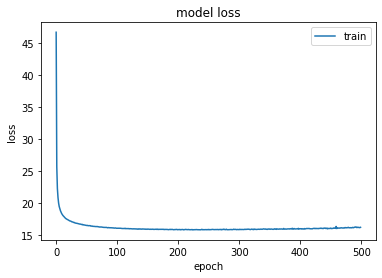

In [29]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [31]:
X_train_pred = vae_model.predict(X_train)

/home/manero/DL/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [38]:
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)
error_thresh = np.quantile(mae_vector, 0.995)
print(error_thresh)

Avg error 0.03758674937027951
median error 0.03660850675639664
99Q: 0.06597148633251958
setting threshold on 0.06597148633251958 
0.07110014312123288


In [39]:
X_pred = vae_model.predict(X_test)
mae_vector = get_error_term(X_pred, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)
print('total non_ignitions',len(X_pred))
print('number of almost_ignitions', np.count_nonzero(anomalies))

#print('total y_test',len(y_test))
#print(np.count_nonzero(y_test))

total non_ignitions 1000000
number of possible_ignitions 124324


In [ ]:
#===== program ends here. now create a new label and label non-ignition dataset with new class ===== #

In [36]:
mae_vector

array([0.08264557, 0.05409973, 0.08828423, ..., 0.15361315, 0.07860929,
       0.05910724])

In [67]:
print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67     10384
         1.0       0.00      0.00      0.00     10384

    accuracy                           0.50     20768
   macro avg       0.25      0.50      0.33     20768
weighted avg       0.25      0.50      0.33     20768



C:\Users\darsh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\darsh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\darsh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
X_pred.shape

(1000000, 22)

In [35]:
X_encoded = encoder.predict(X_test)

In [ ]:


pca = PCA(n_components=2)
X_transform = pca.fit_transform(X_encoded)

In [ ]:
# comparison PCA transformations
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,4))
fig.suptitle('PCA transformations comparison',size=20)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector, ax=ax1)
ax1.set_xlabel('MAE Vector', size=16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies, ax=ax2)
ax2.set_xlabel('Anomalies', size = 16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test, ax=ax3)
ax3.set_xlabel('y_test', size = 16)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test)
plt.grid()
plt.show()

In [ ]:
X_pred.shape

In [ ]:
# figure
error_df = pd.DataFrame({'Reconstruction_error': np.squeeze(mae_vector),
                        'True_class': y_test})

error_df = error_df.sample(frac=1).reset_index(drop=True)
threshold_fixed = 0.06
print(error_thresh)
groups = error_df.groupby('True_class')

fig, ax = plt.subplots(figsize=(18,6))
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Attack" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and attack data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [ ]:
lobal_error = np.squeeze(mae_vector)
Attack_error = error_df[error_df['True_class']==1].Reconstruction_error.to_numpy()
Normal_error = error_df[error_df['True_class']==0].Reconstruction_error.to_numpy()
print(Attack_error.shape, Normal_error.shape)

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,6))
fig.suptitle('Error distributions comparison between different traffic categories',
             size=20)
ax1.hist(Normal_error, bins=150, color='green', alpha=0.6)
ax1.set_xlabel('Normal error', size=14)
ax1.set_ylabel('No of samples', size = 14)
ax2.hist(Attack_error, bins=150, color='pink')
ax2.set_xlabel('Attack error', size = 14)
ax2.set_ylabel('No of samples', size = 14)
ax3.hist(Attack_error, bins=150, color='pink')
ax3.hist(Normal_error, bins=150, color='green', alpha=0.6)
ax3.set_xlabel('Normal and attack', size = 14)
ax3.set_ylabel('No of samples', size = 14)
plt.show()

In [40]:
import session_info
session_info.show(html=False)

-----
keras               2.12.0
matplotlib          3.5.0
numpy               1.22.4
pandas              1.5.3
seaborn             0.11.2
session_info        1.0.0
sklearn             1.2.1
tensorflow          2.12.0
-----
IPython             7.29.0
jupyter_client      8.2.0
jupyter_core        5.3.0
notebook            6.5.4
-----
Python 3.8.12 (default, Oct 12 2021, 13:49:34) [GCC 7.5.0]
Linux-5.19.0-45-generic-x86_64-with-glibc2.17
-----
Session information updated at 2023-06-21 08:12


### 